In [1]:
from pathlib import Path
import os
from BNS_JT import variable, cpm
import config_pm, batch
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import networkx as nx
from matplotlib.lines import Line2D
import pickle
import time

HOME = Path(os.getcwd())
output_path = HOME / "output"

cfg = config_pm.Config_pm(HOME / "input/config.json")
node_coords = {}
for k, v in cfg.infra['nodes'].items():
    node_coords[k] = (v['pos_x'], v['pos_y'])

arcs = {}
for k, v in cfg.infra['edges'].items():
    arcs[k] = [v['origin'], v['destination']]

epi_loc = cfg.infra['eq']['s1']['epicentre']
os_list = cfg.infra['origins']

# Mapping results

Load results

In [2]:
node_pfs = {}
with open(output_path / "result.txt") as f:
    for line in f:
        node, pf, nsamp = line.strip().split("\t")
        node_pfs[node] = float(pf)

print(node_pfs)

{'n63': 0.26757, 'n53': 0.00081841, 'n44': 6.9113e-05, 'n35': 0.0029762, 'n13': 0.0015887, 'n8': 1.7042e-10, 'n4': 5.2637e-06, 'n10': 1.9248e-08, 'n67': 0.019366, 'n39': 0.0082088, 'n30': 0.0012633, 'n48': 6.4212e-06, 'n17': 3.8081e-08, 'n62': 0.3918, 'n57': 0.018534, 'n71': 0.010233, 'n34': 0.0021774, 'n20': 0.00076318, 'n43': 5.4075e-05, 'n52': 3.6391e-05, 'n21': 0.00019239, 'n15': 0.0020479, 'n38': 0.0098154, 'n18': 0.000126, 'n47': 4.9918e-05, 'n12': 0.0017064, 'n56': 0.1816, 'n26': 0.0011094, 'n14': 8.5794e-06, 'n70': 0.34886, 'n33': 4.5435e-05, 'n11': 7.8455e-09, 'n9': 0.0015962, 'n42': 0.012824, 'n6': 7.9404e-11, 'n1': 2.1795e-08, 'n51': 3.619e-06, 'n16': 1.066e-07, 'n74': 0.0014777, 'n60': 0.0011375, 'n28': 0.0024724, 'n72': 0.094308, 'n65': 0.13324, 'n37': 0.0095771, 'n29': 0.0033276, 'n46': 5.5018e-05, 'n24': 0.001056, 'n2': 0.001856, 'n55': 0.082564, 'n69': 0.021127, 'n61': 0.11465, 'n32': 0.0014056, 'n7': 9.7959e-08, 'n41': 0.00016755, 'n50': 8.1016e-07, 'n59': 0.011479, 'n

Interpolate between nodes for visualisation

In [98]:
def draw_pf_map(node_coords, node_pfs, arcs, epi_loc, os_list, Mw):

    coords_list = []
    pfs_list = []
    for k, v in node_coords.items():
        if k in node_pfs:
            coords_list.append(v)
            pfs_list.append(node_pfs[k])

    x_coords = [coord[0] for coord in coords_list]
    y_coords = [coord[1] for coord in coords_list]

    plt.figure()
    grid_x, grid_y = np.mgrid[min(x_coords):max(x_coords):100j, min(y_coords):max(y_coords):100j]
    grid_z = griddata(coords_list, pfs_list, (grid_x, grid_y), method='linear')

    # Create a color map using imshow
    im = plt.imshow(grid_z.T, norm=colors.LogNorm(vmin = 1.0e-12, vmax = 1.0), extent=(min(x_coords), max(x_coords), min(y_coords), max(y_coords)),
            origin='lower', cmap='inferno')
    cbar = plt.colorbar(im) 

    f_size = 15
    font_style = {'size': f_size, 'family': 'Times New Roman'}
    cbar.set_label('Failure probability', fontdict = font_style)
    tick_labels = cbar.ax.get_yticklabels()
    cbar.ax.set_yticklabels(tick_labels, fontdict=font_style)

    # Graph
    G = nx.Graph()
    for k, v in node_coords.items():
        G.add_node(k, pos=v)
    for k,v in arcs.items():
        G.add_edge(v[0], v[1])
    G.add_node('epi', pos=epi_loc)
    node_coords['epi'] = epi_loc

    # Draw the graph
    nx.draw(G, node_coords, nodelist = [n for n in node_coords if n != 'epi'], node_color='k', edge_color='w', node_size=5)

    ## Origin nodes
    nx.draw_networkx_nodes(G, node_coords, nodelist=os_list, node_color='b', node_size=30, node_shape='*' )
    ## Epicentre
    nx.draw_networkx_nodes(G, node_coords, nodelist = ['epi'], node_color='r', node_size=50, node_shape='x')

    ## Legend
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Node',
                            markerfacecolor='k', markersize=5),
                    Line2D([0], [0], marker='*', color='w', label='Origins',
                            markerfacecolor='b', markersize=10),
                    Line2D([0], [0], marker='x', color='w', label=f'Epicentre (Mw={Mw:.1f})',
                            markeredgecolor='r', markersize=6)]
    font_style_l = {'size': f_size, 'family': 'Times New Roman'}
    plt.legend(handles=legend_elements, loc=[-0.15,0.8], prop=font_style_l, handletextpad=0.00001)
    plt.savefig('pf_map1.png', dpi=500)

    # Show the plot
    %matplotlib inline
    plt.show()

C:\Users\jb622s\AppData\Local\Temp\ipykernel_14624\689586365.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(tick_labels, fontdict=font_style)


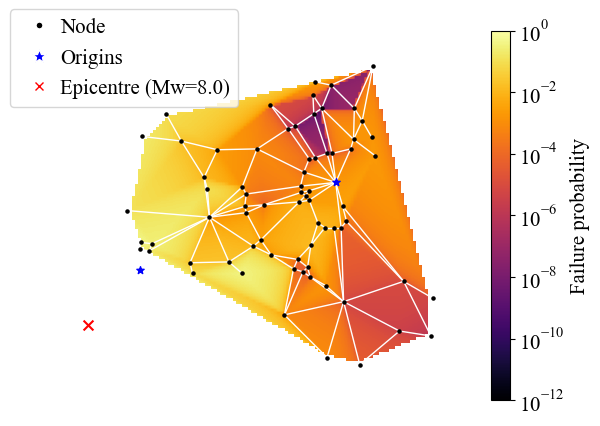

<Figure size 640x480 with 0 Axes>

In [102]:
draw_pf_map(node_coords, node_pfs, arcs, epi_loc, os_list, cfg.infra['eq']['s1']['Mw'], 'pf_map1.png')

# Update the probability

With another scenario 's2' (could be a new hazard scenario or an observed one).

In [5]:
eq_name = 's2'

epi_loc2 = cfg.infra['eq'][eq_name]['epicentre']
pf, MEAN, VAR, COV, Rrup, ln_Sa, std_al, std_ep, frag_mean_beta = batch.cal_edge_dist(cfg.infra, eq_name)
probs = {k: {0:v, 1:1-v} for k,v in pf.items()}

with open(output_path / "varis.pk", 'rb') as f:
    varis = pickle.load(f)


In [20]:
node_pfs2 = {}
node_covs2 = {}
start = time.time()
for node in node_coords:
    if node != 'epi' and node not in os_list:
        with open( output_path / f"cpms_{node}.pk", 'rb') as f:
            cpms = pickle.load(f)

        for k, v in arcs.items():
            cpms[k].p = np.array([probs[k][0], probs[k][1]], dtype=float).T

        if len(cpms[node].Cs) > 0:

            ps = np.zeros_like(cpms[k].q, dtype=float)
            for i in range(len(cpms[k].q)):
                ps[i] = cpm.get_prob(cpms[k], [k], cpms[k].Cs[i])
            cpms[k].ps = ps

            m_unk = cpm.Cpm( [varis[node]], 1, np.array([2]), np.array([1.0]) ) # remove unknown state instances
            is_cmp = cpms[node].iscompatible( m_unk )
            cpms[node] = cpms[node].get_subset( [i for i, v in enumerate(is_cmp) if not v] )

            M_node = cpm.prod_Msys_and_Mcomps(cpms[node], [cpms[k] for k in arcs])
            prob, cov, cint_95 = cpm.get_prob_and_cov( M_node, [node], [0], method='Bayesian' )

        else:
            M_node = cpm.prod_Msys_and_Mcomps(cpms[node], [cpms[k] for k in arcs])
            prob = cpm.get_prob(M_node, [node], [0])
            cov = 0.0
        
        node_pfs2[node] = prob
        node_covs2[node] = cov
end = time.time()

print(f"Time (minutes) taken for update: {(end-start)/60.0:.2f}")
print(node_pfs2)
print(node_covs2)


Time (minutes) taken for update: 10.20
{'n1': 1.658313470640312e-06, 'n2': 0.008557084061361289, 'n3': 2.3112591966213935e-06, 'n4': 0.00010005804110045393, 'n5': 0.00023730037584999712, 'n6': 2.3515171410670555e-08, 'n7': 7.225794936195149e-06, 'n8': 5.3299034110952056e-08, 'n9': 0.006902842265832251, 'n10': 5.877148670615225e-07, 'n11': 3.411800912355246e-07, 'n12': 0.007241151899673315, 'n13': 0.006775054618677133, 'n14': 0.00012663277887856888, 'n15': 0.00851472316841849, 'n16': 6.198167466812274e-06, 'n17': 2.317540070188696e-06, 'n18': 0.00019039107676060703, 'n19': 7.794715042079604e-06, 'n20': 5.872901332908029e-05, 'n21': 8.598516785810278e-06, 'n23': 5.279864831924661e-06, 'n24': 7.821365620091867e-06, 'n25': 2.0649416125869035e-05, 'n26': 8.281384245492206e-06, 'n27': 0.0002529923261150964, 'n28': 2.444009432516875e-05, 'n29': 0.011601135000345151, 'n30': 0.00015371598159584263, 'n31': 9.968927418212017e-06, 'n32': 7.27425674602737e-06, 'n33': 7.754569724799732e-06, 'n34': 1

Draw a map

C:\Users\jb622s\AppData\Local\Temp\ipykernel_14624\689586365.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(tick_labels, fontdict=font_style)


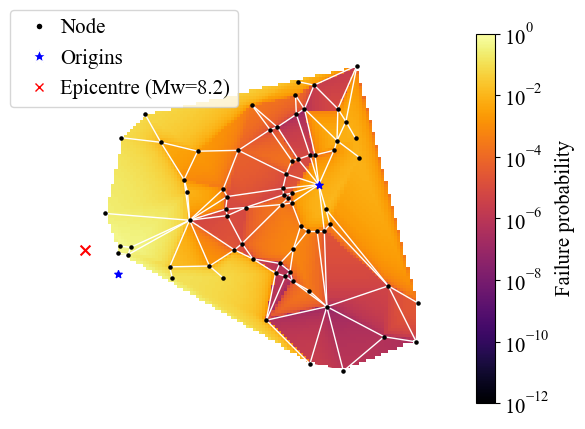

<Figure size 640x480 with 0 Axes>

In [101]:
draw_pf_map(node_coords, node_pfs2, arcs, epi_loc2, os_list,cfg.infra['eq']['s2']['Mw'])
plt.savefig('pf_map2.png', dpi=500)

In [22]:
for k, v in node_covs2.items():
    if v > 0.0:
        print(k, v) 
        print(node_pfs[k], node_pfs2[k])

n30 0.0030887462963142963
0.0012633 0.00015371598159584263
n31 0.011807461429211031
0.00034272 9.968927418212017e-06
n32 0.017679203067604413
0.0014056 7.27425674602737e-06
n34 0.019959942258899833
0.0021774 1.0453115661838908e-05
n35 0.037734804614235916
0.0029762 9.973611090594655e-06
n36 0.02622050454393069
0.0022382 3.667691666923313e-06
n43 0.028835077389322117
5.4075e-05 2.763436488301417e-07
n44 0.015849087901305712
6.9113e-05 9.653528273317072e-07
n45 0.027884689549339668
5.029e-05 8.593374544208972e-08
n46 0.029480516123835846
5.5018e-05 1.071097340864537e-06
n47 0.0312742110350821
4.9918e-05 1.3318846026920768e-07
n48 0.027274339998458685
6.4212e-06 2.6279018644743833e-08
n50 0.02245658260680518
8.1016e-07 2.7461043941579603e-07
n51 0.004146603049869237
3.619e-06 5.279525025370936e-07
n52 0.011038606870795145
3.6391e-05 9.027362992225939e-07
n54 0.01848889115536422
0.00063909 2.741465315584136e-07
n58 0.00012649591350017572
0.002298 0.002071208025287775
n59 0.0001865672555572

In [32]:
node_coords.items()

dict_items([('n1', (62.1517, 75.44)), ('n2', (47.6078, 71.464)), ('n3', (51.5838, 70.6269)), ('n4', (46.98, 68.1157)), ('n5', (36.2028, 65.7092)), ('n6', (49.1773, 64.7675)), ('n7', (57.4432, 64.7675)), ('n8', (47.1892, 63.4073)), ('n9', (59.4312, 61.6285)), ('n10', (40.702, 59.6405)), ('n11', (42.4808, 60.2683)), ('n12', (61.8378, 57.4432)), ('n13', (57.234, 56.9201)), ('n14', (56.5015, 54.5135)), ('n15', (62.7795, 52.7348)), ('n16', (50.5375, 53.3626)), ('n17', (51.7931, 53.3626)), ('n18', (46.0383, 52.0023)), ('n19', (47.6078, 52.3162)), ('n20', (32.8546, 54.5135)), ('n21', (44.6781, 48.6541)), ('n22', (52.7348, 46.0383)), ('n23', (43.841, 45.0966)), ('n24', (44.0503, 43.5271)), ('n25', (46.0383, 43.9456)), ('n26', (45.0966, 42.69)), ('n27', (43.5271, 41.1206)), ('n28', (46.0383, 41.5391)), ('n29', (54.5135, 39.9696)), ('n30', (29.0878, 44.8873)), ('n31', (30.1341, 43.1086)), ('n32', (29.7156, 39.9696)), ('n33', (34.6333, 40.3881)), ('n34', (30.1341, 38.4001)), ('n35', (33.7963, 31.

To draw just the graph.

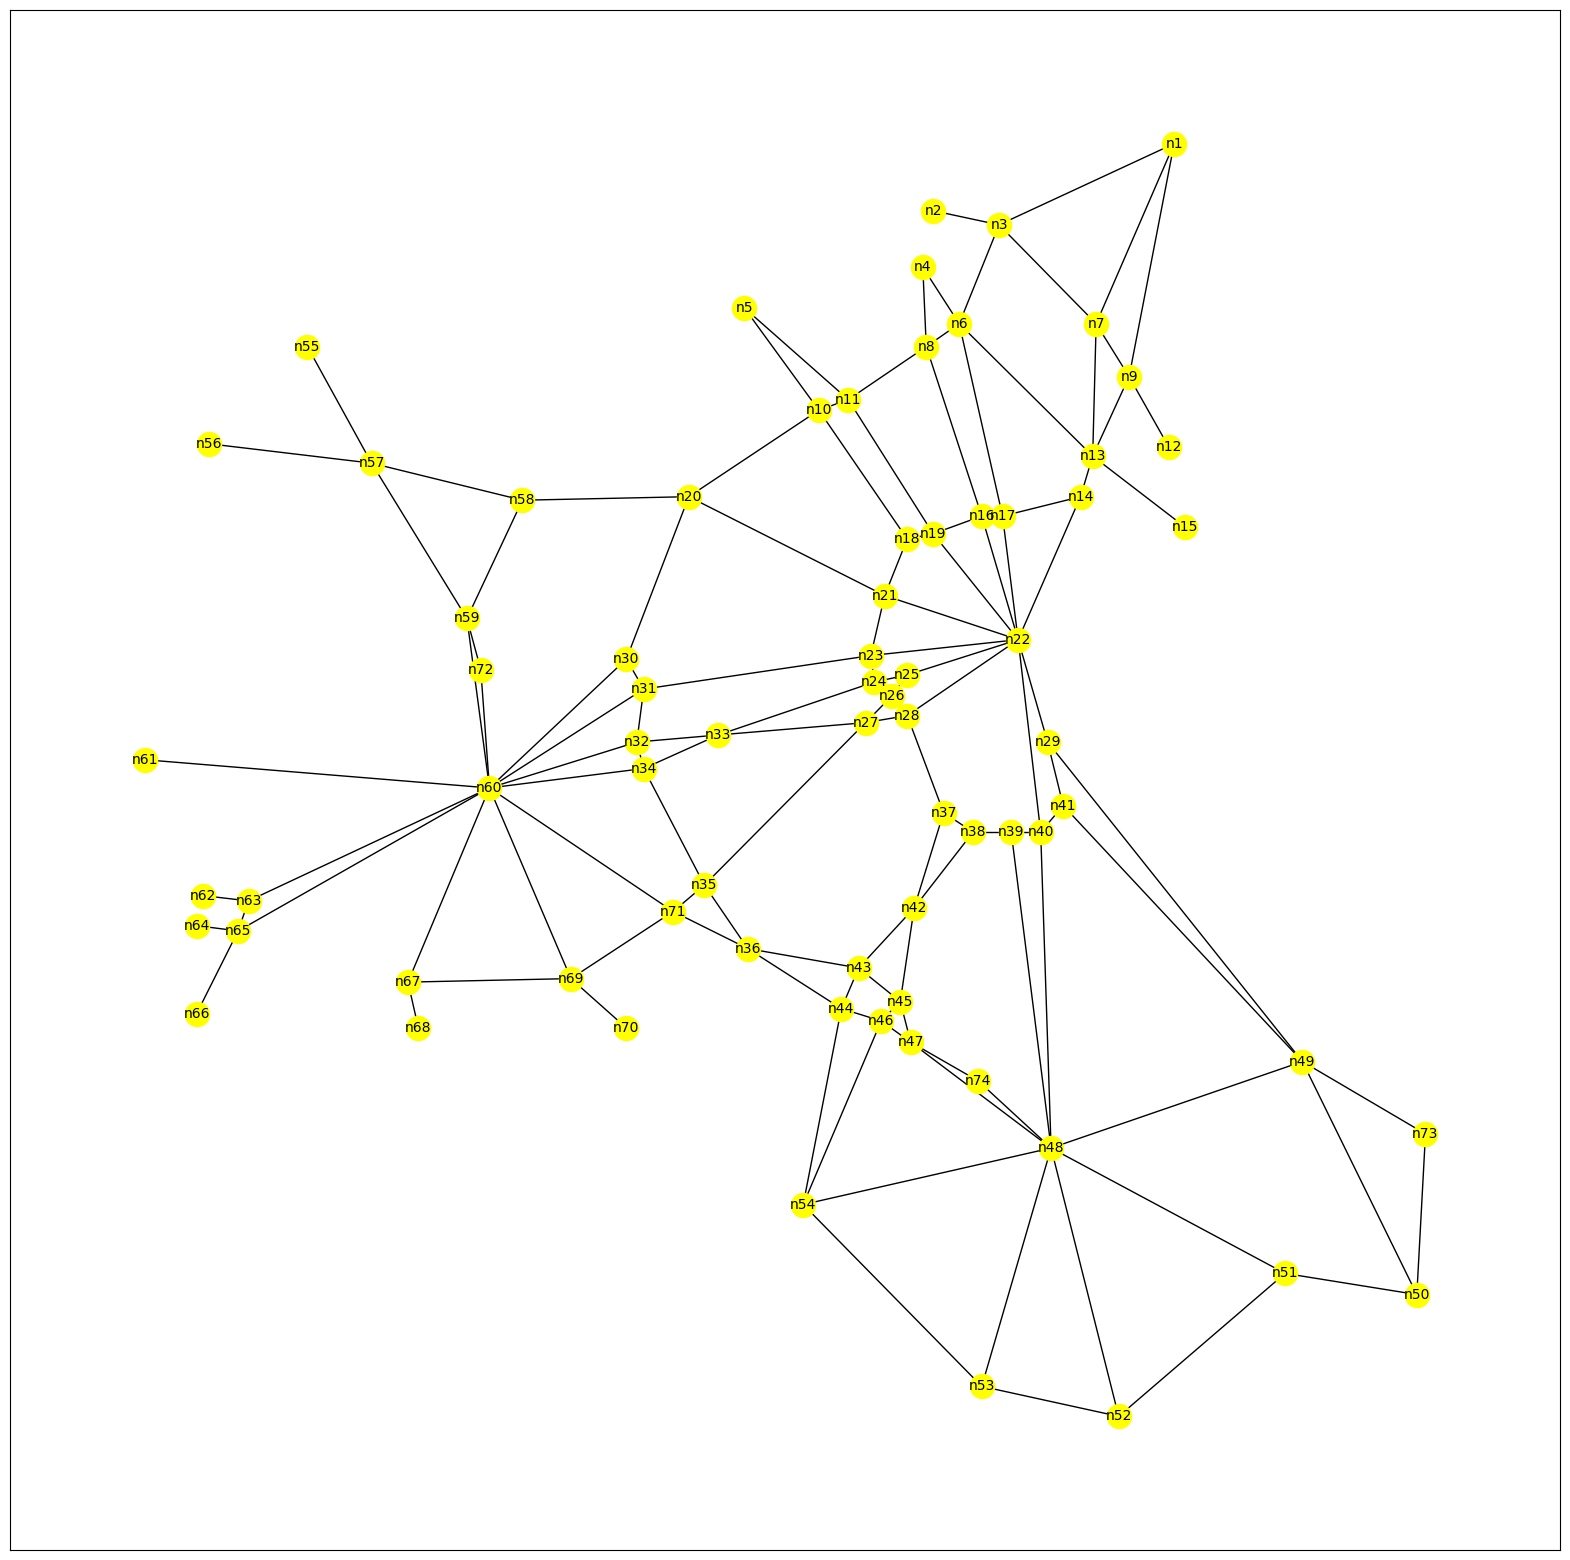

In [39]:
plt.figure(figsize=(20,20))

G = nx.Graph()
for e, v in arcs.items():
    G.add_edge(v[0], v[1], label=e)

for n, v in node_coords.items():
    if n != 'epi':
        G.add_node(n, pos=v)

nx.draw_networkx(G, node_coords, font_size=10, node_color='yellow')

#edge_labels = nx.get_edge_attributes(G, 'label')
#nx.draw_networkx_edge_labels(G, node_coords, edge_labels=edge_labels)

plt.show()